In [1]:
from PIL import Image
from numpy import asarray
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from PIL import Image
from numpy import asarray
import math
import os
from persim import plot_diagrams
from ripser import ripser, lower_star_img
import scipy
from scipy import ndimage

def red_regions_index(img_array, n):
    a = img_array.shape[0]
    b = img_array.shape[1]
    A = np.arange(a)
    B = np.arange(b)
    C = list(product(A, B))
    
    max_val = img_array[:,:,0].max()
    prob = img_array.astype(np.float64)
    prob = 1/max_val * img_array
    prob = np.exp((np.exp(np.exp(prob))))
    max_sum = np.sum(prob[:,:,0])
    prob = 1/max_sum * prob
    prob = prob[:,:,0].flatten()

    index_regions = np.random.choice(len(C), n, replace = False, p = prob)
    return index_regions, C

def red_regions(img_array, n):
    list_red_regions = []
    region_indexes, C = red_regions_index(img_array, n)
    for x in region_indexes:
        if len(img_array[C[x][0]:(C[x][0] + 10), C[x][1]:(C[x][1] + 10)]) == 10:
            list_red_regions.append(img_array[C[x][0]:(C[x][0] + 10), C[x][1]:(C[x][1] + 10)][:,:,0])
    return list_red_regions

In [3]:
from scipy import sparse
def test_lower_star_img(img):
    """
    Construct a lower star filtration on an image

    Parameters
    ----------
    img: ndarray (M, N)
        An array of single channel image data

    Returns
    -------
    I: ndarray (K, 2)
        A 0-dimensional persistence diagram corresponding to the sublevelset filtration
    """
    m, n = img.shape

    idxs = np.arange(m * n).reshape((m, n))

    I = idxs.flatten()
    J = idxs.flatten()
    V = img.flatten()

    # Connect 8 spatial neighbors
    tidxs = np.ones((m + 2, n + 2), dtype=np.int64) * np.nan
    tidxs[1:-1, 1:-1] = idxs

    tD = np.ones_like(tidxs) * np.nan
    tD[1:-1, 1:-1] = img

    for di in [-1, 0, 1]:
        for dj in [-1, 0, 1]:

            if di == 0 and dj == 0:
                continue

            thisJ = np.roll(np.roll(tidxs, di, axis=0), dj, axis=1)
            thisD = np.roll(np.roll(tD, di, axis=0), dj, axis=1)
            thisD = np.maximum(thisD, tD)

            # Deal with boundaries
            boundary = ~np.isnan(thisD)
            thisI = tidxs[boundary]
            thisJ = thisJ[boundary]
            thisD = thisD[boundary]

            I = np.concatenate((I, thisI.flatten()))
            J = np.concatenate((J, thisJ.flatten()))
            V = np.concatenate((V, thisD.flatten()))

    sparseDM = sparse.coo_matrix((V, (I, J)), shape=(idxs.size, idxs.size))

    return ripser(sparseDM, distance_matrix=True, maxdim=1)["dgms"]

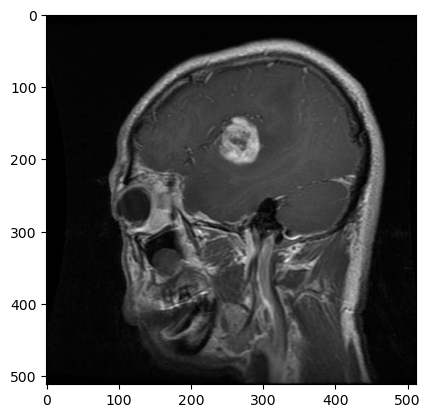

In [60]:
img = Image.open("C:/Users\hafid\OneDrive\Documents\Final Project\Training\glioma_tumor\gg (270).jpg")
img_array = asarray(img)
plt.imshow(1/255 * img_array[:,:,0])
plt.gray()

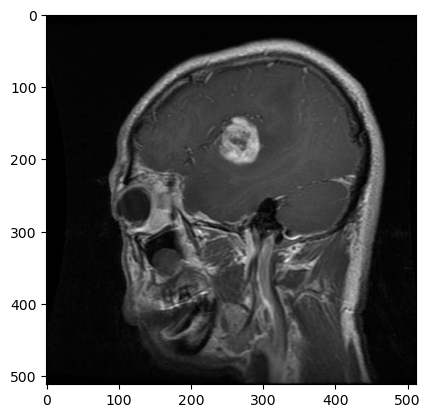

In [61]:
one_channel_img = 1/255 * img_array[:,:,0]
plt.imshow(one_channel_img)
plt.gray()

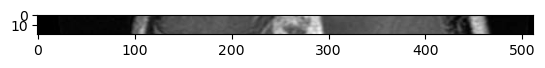

In [64]:
plt.imshow(one_channel_img[160:180:,])

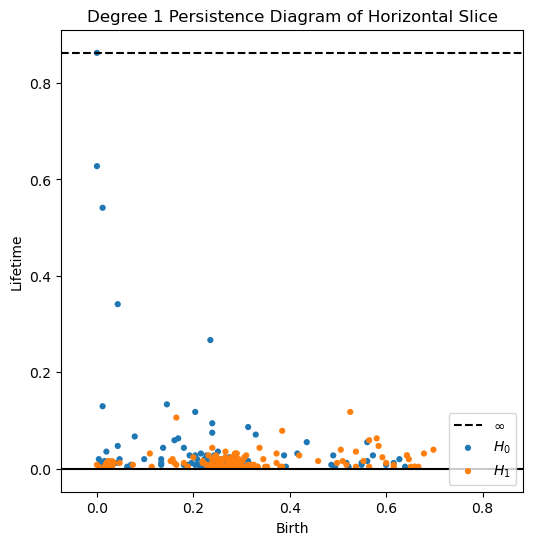

In [65]:
dgm1 = test_lower_star_img(one_channel_img[160:180:,])
plt.figure(figsize=(6, 6))
plot_diagrams(dgm1, lifetime=True, title = 'Degree 1 Persistence Diagram of Horizontal Slice')
plt.show()

In [66]:
hor_slice1_ls = PersLandscapeApprox(dgms = dgm1, hom_deg = 1)

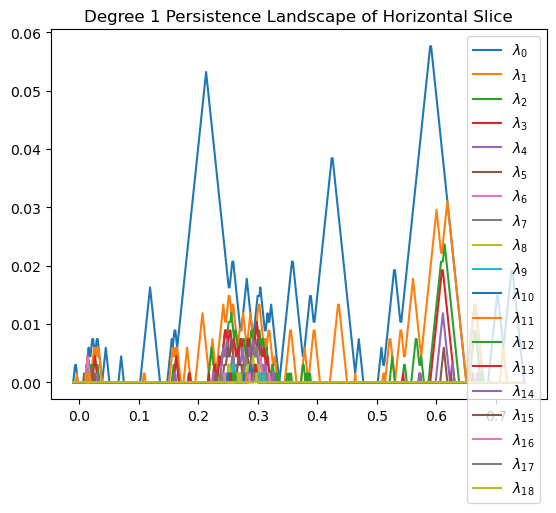

In [67]:
import persim
plot_landscape_simple(hor_slice1_ls,title='Degree 1 Persistence Landscape of Horizontal Slice')

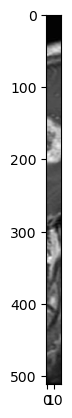

In [68]:
plt.imshow(one_channel_img[:,270:290])
plt.gray()

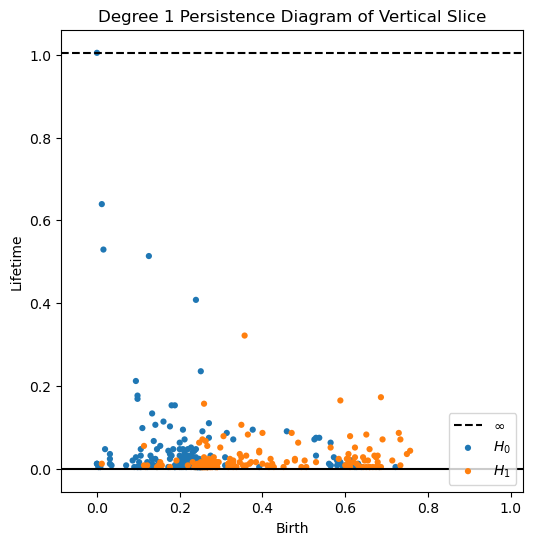

In [69]:
dgm2= test_lower_star_img(one_channel_img[:,270:290])
plt.figure(figsize=(6, 6))
plot_diagrams(dgm2, lifetime=True, title = 'Degree 1 Persistence Diagram of Vertical Slice')
plt.show()

In [70]:
ver_slice1_ls = PersLandscapeApprox(dgms = dgm2, hom_deg = 1)

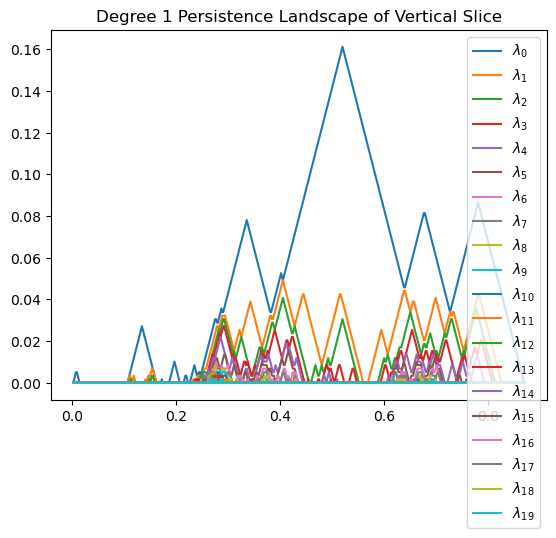

In [71]:
plot_landscape_simple(ver_slice1_ls,title='Degree 1 Persistence Landscape of Vertical Slice')

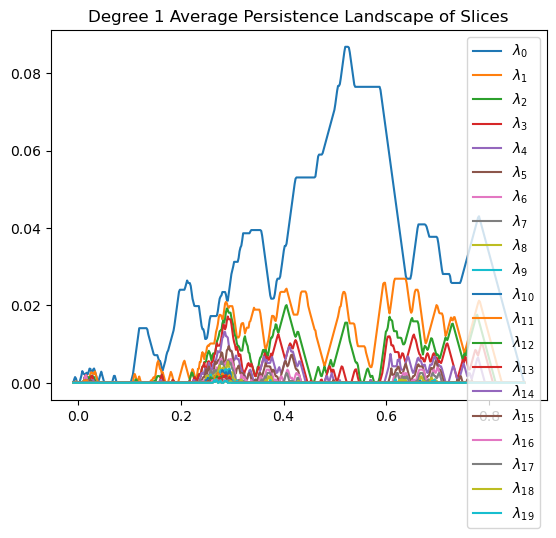

In [72]:
landscapes = []
landscapes.append(hor_slice1_ls)
landscapes.append(ver_slice1_ls)
avg_ls = average_approx(landscapes)
plot_landscape_simple(avg_ls,title='Degree 1 Average Persistence Landscape of Slices')

In [73]:
from ripser import ripser
from persim.landscapes import (
    PersLandscapeApprox,
    average_approx,
    snap_pl,
    plot_landscape,
    plot_landscape_simple
)


In [74]:
def gen_horizontal_slices(width, img_array):
    rows = img_array.shape[0]
    hor_ls = []
    n = int(np.floor(rows/width))
    for i in range(n):
        hor_slice = img_array[i*width : (i+1) * width,:]
        dgm = test_lower_star_img(hor_slice)
        plt.figure(figsize=(6, 6))
        plot_diagrams(dgm, lifetime=True) 
        if len(dgm[1])!= 0:
            hor_slice_ls = PersLandscapeApprox(dgms = dgm, hom_deg = 1)
            hor_ls.append(hor_slice_ls)
    rem_rows = rows - (n * width)
    if rem_rows != 0:
        hor_slice = img_array[n * width : rows,:]
        dgm = test_lower_star_img(hor_slice)
        plt.figure(figsize=(6, 6))
        plot_diagrams(dgm, lifetime=True)
        if len(dgm[1])!= 0:
            hor_slice_ls = PersLandscapeApprox(dgms = dgm, hom_deg = 1)
            hor_ls.append(hor_slice_ls)
    return hor_ls
        
def gen_vertical_slices(width, img_array):
    cols= img_array.shape[1]
    ver_ls = []
    n = int(np.floor(cols/width))
    for i in range(n):
        ver_slice = img_array[:, i*width : (i+1) * width]
        dgm = test_lower_star_img(ver_slice)
        plt.figure(figsize=(6, 6))
        plot_diagrams(dgm, lifetime=True)
        if len(dgm[1])!= 0:
            ver_slice_ls = PersLandscapeApprox(dgms = dgm, hom_deg = 1)
            ver_ls.append(ver_slice_ls)    
    rem_cols = cols - (n * width)
    if rem_cols != 0:
        ver_slice = img_array[:, n * width : cols]
        dgm = test_lower_star_img(ver_slice)
        plt.figure(figsize=(6, 6))
        plot_diagrams(dgm, lifetime=True)
        if len(dgm[1])!= 0:
            ver_slice_ls = PersLandscapeApprox(dgms = dgm, hom_deg = 1)
            ver_ls.append(ver_slice_ls)
    return ver_ls

In [75]:
def avg_ls(width, img_array):
    one_channel_img = 1/255 * img_array[:,:,0]
    hor_ls = gen_horizontal_slices(width, one_channel_img) 
    ver_ls = gen_vertical_slices(width, one_channel_img)
    hor_ls.extend(ver_ls)
    avg_ls = average_approx(hor_ls)
    return avg_ls

In [76]:
import os

import pickle

def list_of_folders():
    data_folder_path = "C:/Users/hafid/OneDrive/Documents/Final Project/Training" # path to the folder on your computer
    folder_dir_list = os.listdir(data_folder_path)

    return folder_dir_list

In [ ]:
pers_LS_list = avg_ls(20, img_array)

In [29]:
outfilez = open("C:/Users\hafid\OneDrive\Documents\Final Project\Training\glioma_tumor\gg (340).jpg" + 'pers_LS1.pckl', 'wb')
pickle.dump(list(pers_LS_list), outfilez)
outfilez.close()

In [35]:
with open("C:/Users/hafid/OneDrive/Documents/Final Project/brain_mri_LS/glioma_tumor_pers_LS/gg (1).jpgpers_LS.pckl", 'rb') as handle:
    tst = pickle.load(handle)

In [8]:
def pers_ls_folders():
    folder_dir_list = list_of_folders()
    width = 20
    for folder in folder_dir_list[3:4]: #LIS[1:4]
        folder_path = "C:/Users/hafid/OneDrive/Documents/Final Project/Training" + '/' + folder
        brain_LS_path = "C:/Users/hafid/OneDrive/Documents/Final Project/brain_mri_LS"
        if not os.path.exists(brain_LS_path + '/' + folder + '_pers_LS'):
            os.makedirs(brain_LS_path + '/' + folder + '_pers_LS')
        
        dir_list = os.listdir(folder_path)
        for x in dir_list[340:]: #remove the indexing
            img = Image.open(folder_path + '/' + x)
            img_array = asarray(img)
            pers_LS_list = avg_ls(width, img_array)
            outfilez = open(brain_LS_path + '/' + folder + '_pers_LS' + '/' + x + 'pers_LS.pckl', 'wb')
            pickle.dump(list(pers_LS_list), outfilez)
            outfilez.close()

In [ ]:
pers_ls_folders()